In [14]:
'''Data preprocessing'''
import os
import re
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 
# Set the desired directory for data
desired_directory = r'D:\OneDrive - Hong Kong Metropolitan University\2.Liuyang\20231229machine_learning_blood'
os.chdir(desired_directory)

# Read data from Excel file
file = "20210101-20230630C14.xls"
data_v0 = pd.read_excel(file)

# Select specific columns and rename them
selected_columns = data_v0.iloc[:, [4, 1, 2, 6]]
selected_columns.columns = ["Outcome", "Gender", "Age", "exposure"]

# Create 'outcome' values based on '阴' and '阳'
selected_columns['Outcome'] = selected_columns['Outcome'].apply(lambda x: 0 if '阴' in x else (1 if '阳' in x else None))

# Map 'gender' values to 1 for '男' and 0 for '女'
selected_columns['Gender'] = selected_columns['Gender'].map({'男': 1, '女': 0})

# Define a regex pattern to extract data from 'exposure' column
pattern = r'\[(.*?)\:(.*?)\]'
selected_columns['exposure'] = selected_columns['exposure'].apply(lambda x: re.findall(pattern, x))

# Extract blood data into separate columns
blood = selected_columns['exposure'].apply(lambda x: pd.Series(dict(x)))

# Remove rows with invalid data
blood = blood[~blood.apply(lambda row: any(row.astype(str).str.contains(r'[ =R]')), axis=1)]

# Rename blood data columns
new_column_names = {'白细胞': 'WBC',
                    '淋巴细胞百分比': 'Lymph%',
                    '单核细胞百分比': 'Mono%',
                    '中性粒细胞百分比': 'Neut%',
                    '红细胞': 'RBC',
                    '血红蛋白': 'Hb',
                    '红细胞比积': 'HCT',
                    '平均红细胞体积': 'MCV',
                    '平均血红蛋白含量': 'MCH',
                    '平均血红蛋白浓度': 'MCHC',
                    '红细胞体积分布宽度': 'RDW',
                    '血小板': 'PLC',
                    '平均血小板体积': 'MPV',
                    '血小板体积分布宽度': 'PDW',
                    '嗜酸性粒细胞百分比': 'Eos%',
                    '嗜碱性粒细胞百分比': 'Baso%',
                    '血小板压积': 'PCT',
                    '超敏C反应蛋白': 'CRP',
                    '淋巴细胞绝对值': 'ALC',
                    '单核细胞绝对值': 'AMC',
                    '中性粒细胞绝对值': 'ANC',
                    '嗜酸性粒细胞绝对值': 'AEC',
                    '嗜碱性粒细胞绝对值': 'ABC'}
blood.rename(columns=new_column_names, inplace=True)

# Select columns to keep
columns_to_keep = ['WBC', 'RBC', 'Hb', 'ALC', 'AMC', 'ANC', 'AEC', 'ABC', 'Baso%', 'Eos%', 'Lymph%', 'Mono%', 'Neut%', 'PDW', 'HCT', 'MCV', 'MCH', 'MCHC', 'RDW', 'PLC', 'MPV', 'PCT', 'CRP']
blood = blood.loc[:, columns_to_keep]

# Merge cleaned dataframes
merged_df = pd.concat([selected_columns.iloc[:, :3], blood], axis=1)

# Create copies of the cleaned dataset for further processing
data_v2 = merged_df.copy()
data_v3 = merged_df.copy()

# Define a function to process values in blood data
def process_value(value):
    if value is not None and not isinstance(value, float):
        if isinstance(value, str) and '<' in value:
            return 0
        elif isinstance(value, str) and '>' in value:
            return None
        else:
            match = re.match(r"(\d+\.\d+|\d+)\((\d+\.\d+|\d+)-(\d+\.\d+|\d+)\)", value)
            if match:
                main_val = float(match.group(1))
                lower_val = float(match.group(2))
                upper_val = float(match.group(3))
                return (main_val-lower_val)/(upper_val-lower_val)
            return value
    return value

# Process values in blood data columns
for column in data_v2.iloc[:, 3:]:
    data_v2[column] = data_v2[column].apply(process_value)

# Define a function to extract the main value from blood data
def extract_main_value(value):
    if value is not None and not isinstance(value, float):
        if isinstance(value, str) and ('<' in value or '>' in value):
            return 0
        else:
            match = re.match(r"(\d+\.\d+|\d+)\((\d+\.\d+|\d+)-(\d+\.\d+|\d+)\)", value)
            if match:
                return float(match.group(1))
            return value
    return value

# Extract main values from blood data columns
for column in data_v3.iloc[:, 3:]:
    data_v3[column] = data_v3[column].apply(extract_main_value)

# Filter data based on the 'outcome' column
hpi_data = data_v3[data_v3['Outcome'] == 1]
nhpi_data = data_v3[data_v3['Outcome'] == 0]

# Display missing values count
print(len(hpi_data))
print(hpi_data.isnull().sum())
print(len(nhpi_data))
print(nhpi_data.isnull().sum())

# Drop rows with missing values
data_v2=data_v2.dropna()
data_v3 = data_v3.dropna()

data_v2.to_csv('range transfer data.csv', index=False)
data_v3.to_csv('clean data.csv', index=False)

376
Outcome    0
Gender     0
Age        0
WBC        2
RBC        2
Hb         2
ALC        2
AMC        2
ANC        2
AEC        2
ABC        2
Baso%      2
Eos%       2
Lymph%     2
Mono%      2
Neut%      2
PDW        2
HCT        2
MCV        2
MCH        2
MCHC       2
RDW        2
PLC        2
MPV        2
PCT        2
CRP        4
dtype: int64
1050
Outcome     0
Gender      0
Age         0
WBC         1
RBC         1
Hb          1
ALC         1
AMC         1
ANC         1
AEC         1
ABC         1
Baso%       1
Eos%        1
Lymph%      1
Mono%       1
Neut%       1
PDW         1
HCT         1
MCV         1
MCH         1
MCHC        1
RDW         1
PLC         1
MPV         1
PCT         1
CRP        13
dtype: int64


In [15]:
'''Data description'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency

# ANSI escape sequences for colors and styles
YELLOW = '\033[93m'  # Yellow text color
BOLD = '\033[1m'  # Bold text style
RESET = '\033[0m'  # Reset text color and style

# Setting display options
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Automatically adjust display width to accommodate content

# Load data from Excel file
data = pd.read_csv('clean data.csv')

# Count and display values in the 'Diagnosis' column
outcome_counts = data['Outcome'].value_counts()
print(BOLD + YELLOW + "Outcome count:" + RESET)
print(outcome_counts)

# Create a pivot table to analyze categorical variables by 'Diagnosis' and display
result = data.pivot_table(index='Outcome', columns='Gender', aggfunc='size', fill_value=0).T
print(BOLD + YELLOW + 'Category variables:' + RESET)
print(result.round(3))  # Round to three decimal places for clarity

# Compute descriptive statistics for each 'Diagnosis'
grouped_stats = data.groupby('Outcome').describe()
grouped_means = grouped_stats.xs('mean', level=1, axis=1)  # Extract mean values
grouped_stds = grouped_stats.xs('std', level=1, axis=1)  # Extract standard deviation values
print(BOLD + YELLOW + "Mean categorized by Outcome:" + RESET)
print(grouped_means.round(3))  # Display means rounded to three decimal places
print(BOLD + YELLOW + "Standard deviation categorized by Outcome:" + RESET)
print(grouped_stds.round(3))  # Display standard deviations rounded to three decimal places

# Perform independent samples t-tests for each variable and display results
t_tests = {}
variables = data.columns.drop(['Gender', 'Outcome'])  # Exclude non-numeric and outcome columns
outcomes = data['Outcome'].unique()
significant_vars = []
for var in variables:
    groups = [data[data['Outcome'] == outcome][var] for outcome in outcomes]
    t_stat, p_val = stats.ttest_ind(*groups, equal_var=False)
    t_tests[var] = {'t-statistic': round(t_stat, 3), 'p-value': round(p_val, 3)}
    if p_val < 0.05:  # Identify variables with significant differences
        significant_vars.append(var)

print(BOLD + YELLOW + "Results of independent samples t-tests:" + RESET)
print(t_tests)
df = pd.DataFrame.from_dict(t_tests, orient='index')
print(df)

# Perform Chi-square test for 'Gender' and 'Diagnosis' and display results
contingency_table = pd.crosstab(data['Gender'], data['Outcome'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(BOLD + YELLOW + "Chi-square test results:" + RESET)
print("Chi-Square Statistic:", round(chi2, 3), "p-value:", round(p, 3))

Outcome count:
Outcome
0    1037
1     372
Name: count, dtype: int64
Category variables:
Outcome    0    1
Gender           
0        589  222
1        448  150
Mean categorized by Outcome:
         Gender     Age    WBC    RBC       Hb    ALC    AMC    ANC    AEC  \
Outcome                                                                      
0         0.432  54.943  5.308  4.398  133.029  1.455  0.337  3.384  0.102   
1         0.403  54.204  5.582  4.358  132.166  1.533  0.358  3.553  0.102   

           ABC  Baso%   Eos%  Lymph%  Mono%   Neut%     PDW    HCT     MCV  \
Outcome                                                                      
0        0.020  0.591  1.953  28.376  6.496  62.584  16.684  0.399  91.049   
1        0.019  0.565  1.907  28.286  6.493  62.749  16.609  0.396  91.096   

           MCH     MCHC     RDW      PLC    MPV    PCT    CRP  
Outcome                                                        
0        30.36  333.237  13.082  206.850  8.913  0.181  

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17976\1195918495.py:33: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(data=melted_data, x='Variables', y='Distribution', hue='Outcome', fill=False, split=True,


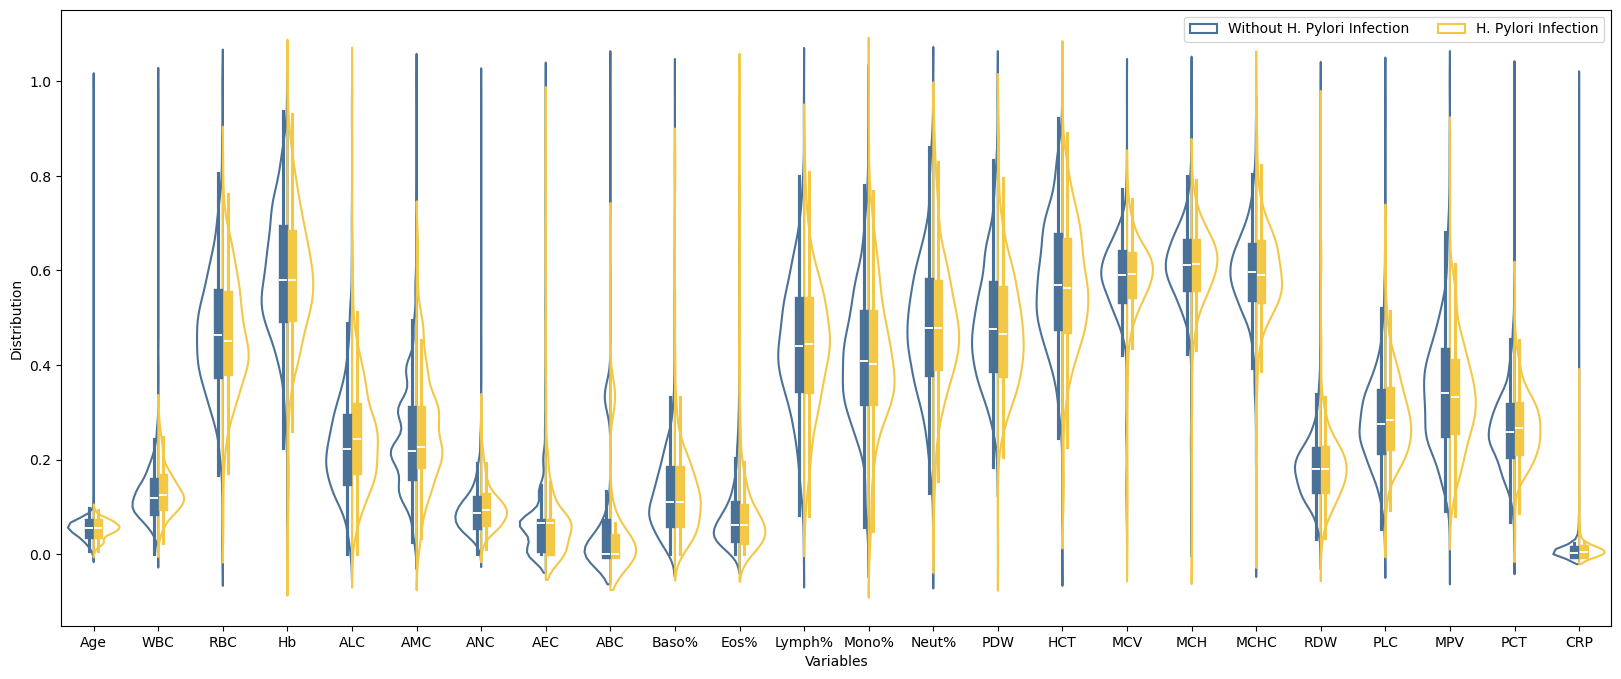

In [40]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset from a CSV file
data = pd.read_csv('clean data.csv')

# Drop the 'Gender' column from the dataset
data_drop = data.drop(columns=['Gender'])

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the data excluding the 'Gender' column
scaled_data = scaler.fit_transform(data_drop)

# Convert the scaled data back into a DataFrame, including the original column names
data_to_plot = pd.DataFrame(scaled_data, columns=data_drop.columns)

# Replace the binary outcomes in the 'Outcome' column with more descriptive labels
data_to_plot['Outcome'] = data_to_plot['Outcome'].replace({0: 'Without H. Pylori Infection', 1: 'H. Pylori Infection'})

# Melt the DataFrame to format it for a violin plot, specifying 'Outcome' as the identifier variable
melted_data = data_to_plot.melt(id_vars='Outcome', var_name='Variables', value_name='Distribution')

# Set up the plotting environment and define the size of the figure
plt.figure(figsize=(20, 8))

# Create a violin plot to visualize the distribution of variables split by 'Outcome'
sns.violinplot(data=melted_data, x='Variables', y='Distribution', hue='Outcome', fill=False, split=True,
               scale='count',inner='box',palette=sns.color_palette(['#4A7298', '#F3C846']))

# Add a legend to the plot with custom placement and column settings
plt.legend(loc='upper right', ncol=2)

# Display the plot
plt.show()

In [29]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

# Load data from CSV file
data = pd.read_csv('range transfer data.csv')

# Separating the features and the target variable
X = data.drop('Outcome', axis=1)  # Features
y = data['Outcome']  # Target variable

# Apply RandomOverSampler for oversampling
smote = RandomOverSampler(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a StandardScaler object
scaler = StandardScaler()

# Scale the features
X_scaled = scaler.fit_transform(X_resampled)

# Convert the scaled features back into a DataFrame with appropriate column names
scaled_data_df = pd.DataFrame(X_scaled, columns=X.columns)

# Combine scaled features with target variable
data_resampled = pd.concat([scaled_data_df, pd.Series(y_resampled, name='Outcome')], axis=1)

# Save the DataFrame to a CSV file
data_resampled.to_csv('scaled_data_with_RandomOverSampler.csv', index=False)

# Display the head of the scaled DataFrame
print(data_resampled.head())

# Display value counts of the target variable
print(data_resampled['Outcome'].value_counts())

     Gender       Age       WBC       RBC        Hb       ALC       AMC  \
0  1.184586 -0.357119 -0.435804 -0.594851  0.317648  1.020019  0.372346   
1  1.184586  0.077735  0.749615  0.867287 -0.175306  1.020019  0.372346   
2 -0.844177  0.621302 -0.857422  0.984950  1.411322 -1.239634 -0.492027   
3  1.184586  0.240805 -0.429694 -1.269683  0.101047  0.011245  0.372346   
4 -0.844177  0.893085  0.071360  0.102476  0.316581  0.011245 -0.347965   

        ANC       AEC       ABC  ...       HCT       MCV       MCH      MCHC  \
0 -1.027224  1.614137 -0.519715  ...  0.129121  1.123741  1.292364  0.908382   
1  0.304171  1.614137  2.166948  ...  0.438152 -0.812628 -1.252660 -1.614847   
2 -0.445615 -0.597472  0.017617  ...  1.488859  0.542094  0.230013 -0.495949   
3 -0.536710 -0.024092 -0.519715  ... -0.149008  2.012777  2.086818  0.999721   
4  0.023877  0.795023  2.166948  ...  0.190927  0.124265  0.151491  0.154839   

        RDW       PLC       MPV       PCT       CRP  Outcome  
0  0.

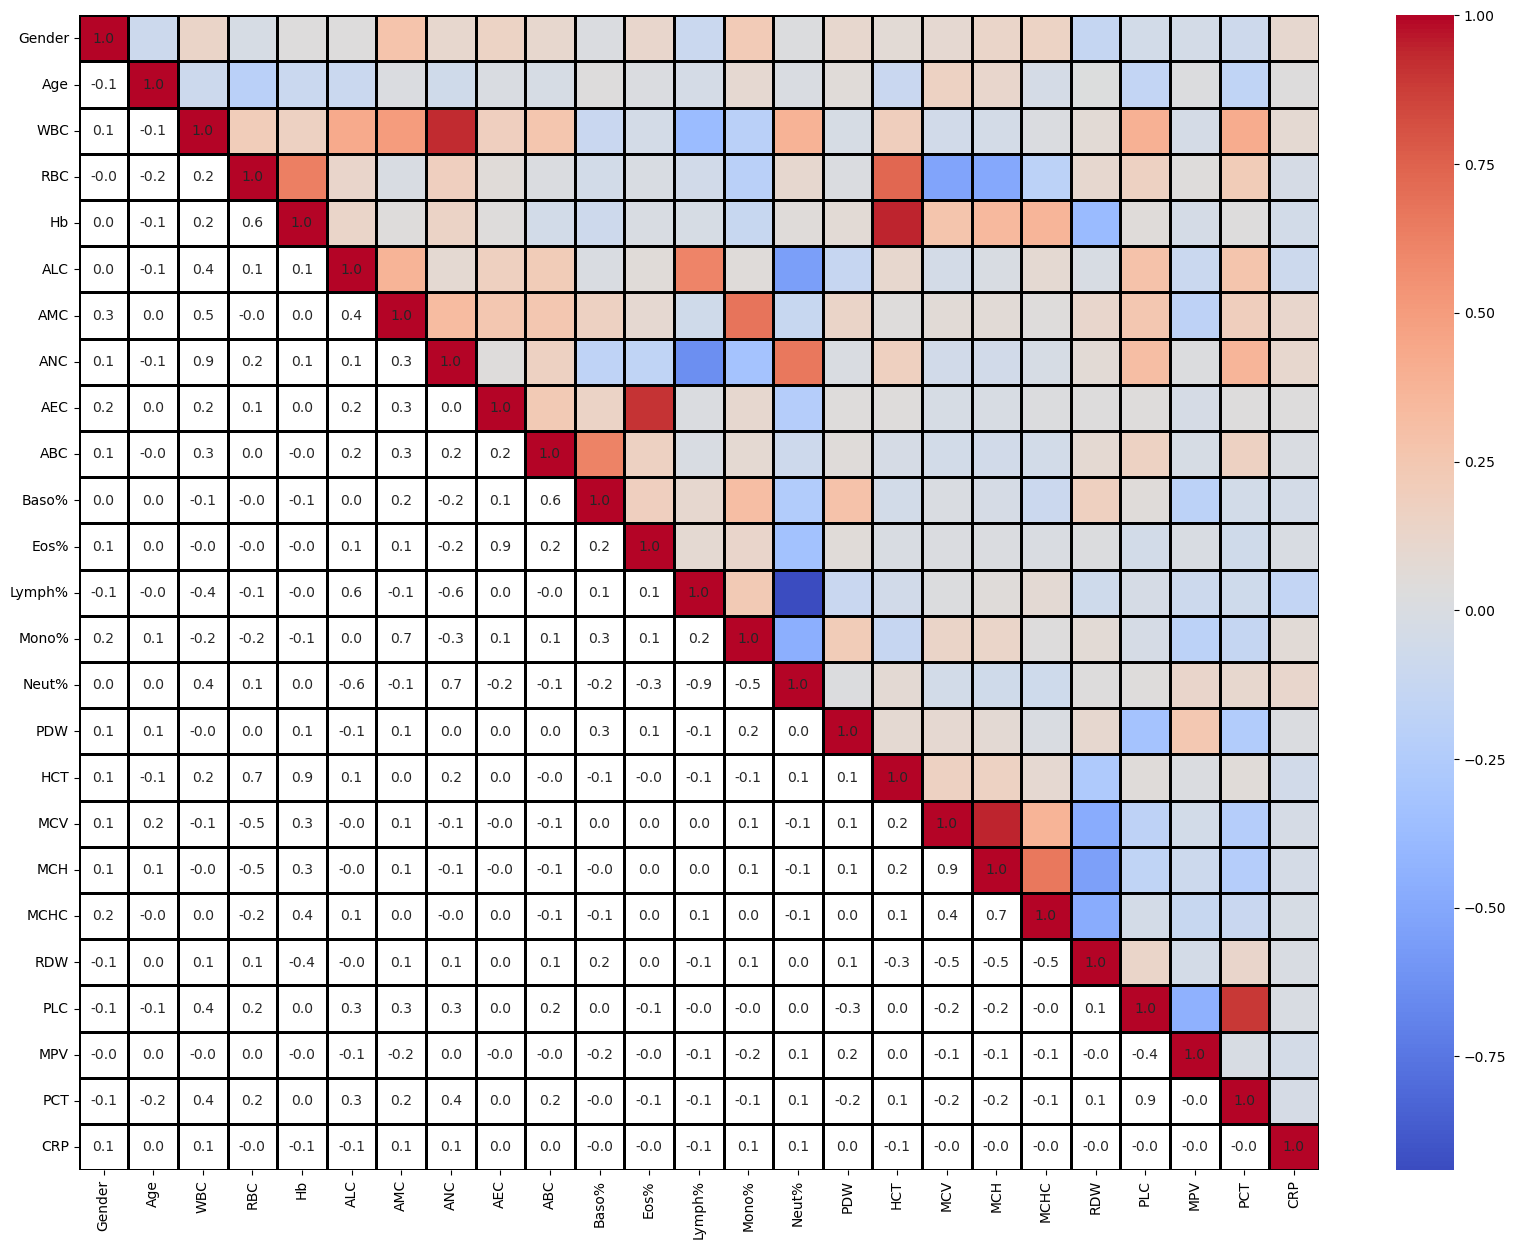

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Load data
data = pd.read_csv('scaled_data_with_RandomOverSampler.csv')

# Calculate the correlation matrix
correlation_matrix = data.iloc[:, :-1].corr()

# Transpose the correlation matrix for 90-degree rotation
correlation_matrix = correlation_matrix.T

# Create mask to hide the diagonal and display only one triangle (keep numbers in one triangle)
mask = np.ones_like(correlation_matrix, dtype=bool)
np.fill_diagonal(mask, True)
mask = np.tril(mask)  # Change to lower triangle for the rotated matrix

# Create a figure object
plt.figure(figsize=(20, 15))

# For the lower triangle, display numbers without color blocks
sns.heatmap(correlation_matrix, mask=~mask,annot=True,cmap=['white'], fmt='.1f',cbar=False)

np.fill_diagonal(mask, False)
# Plot the heatmap, diagonal not shown, upper triangle does not display numbers
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=False, cbar=True, linewidths=1, linecolor='black')

# Display the plot
plt.show()

Accuracy: 0.563855421686747
ROC AUC Score: 0.564120736127893
Confusion Matrix:
[[117  86]
 [ 95 117]]
Gender   -0.096582
Age      -0.132503
WBC       0.000000
RBC      -0.749151
Hb        0.377213
ALC       0.252843
AMC       0.159501
ANC      -0.016507
AEC      -0.104472
ABC      -0.100437
Baso%     0.101124
Eos%      0.103824
Lymph%   -0.217936
Mono%    -0.066527
Neut%     0.000000
PDW      -0.149451
HCT       0.218727
MCV      -0.154038
MCH      -0.290512
MCHC      0.000000
RDW       0.000000
PLC      -0.453287
MPV      -0.230067
PCT       0.350314
CRP       0.028933
dtype: float64


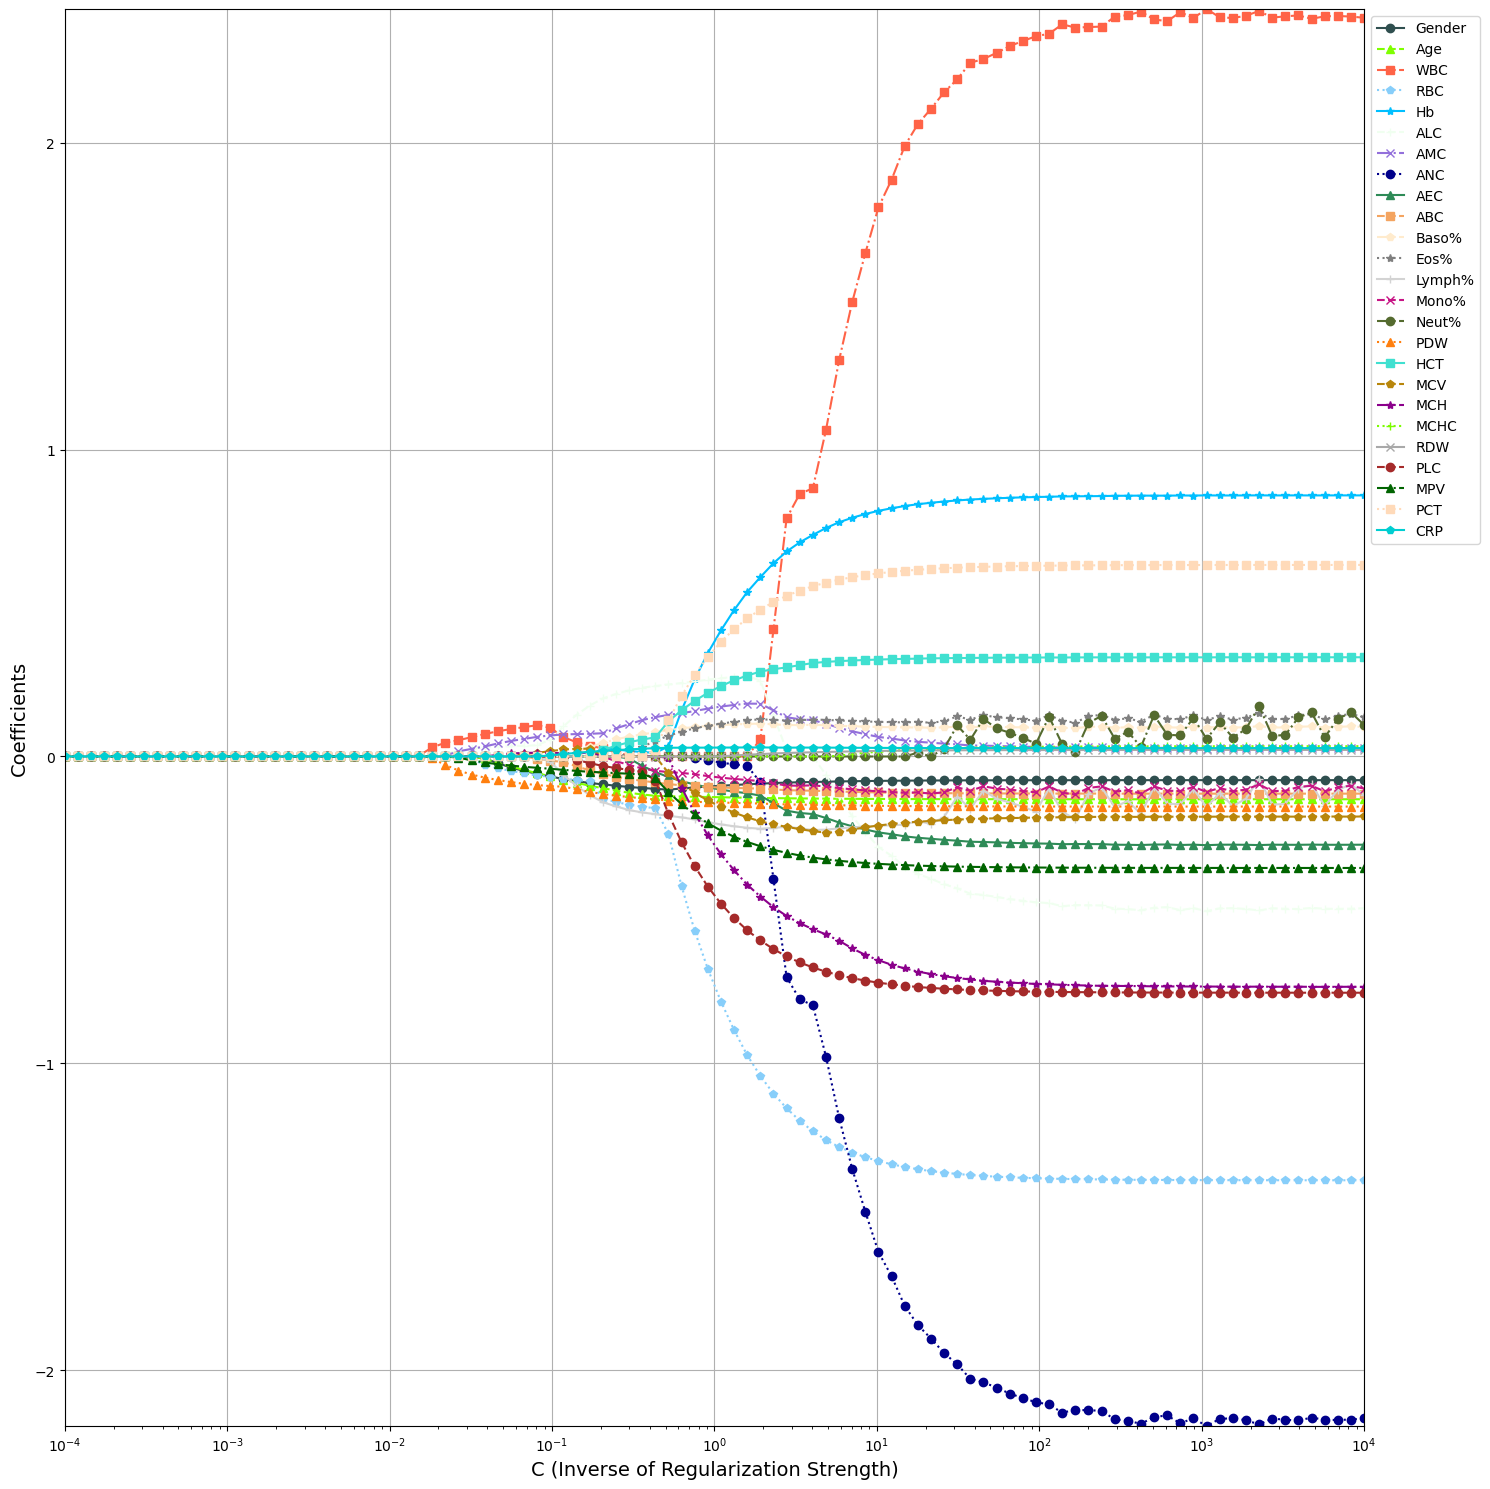

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Load the data from a CSV file
data = pd.read_csv('scaled_data_with_RandomOverSampler.csv')

# Separate the target variable and features
y = data['Outcome']  # target variable
X = data.drop('Outcome', axis=1)  # features
features = X.columns  # store feature names for later use

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Initialize Logistic Regression model with L1 regularization
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

# Output model evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Confusion Matrix:\n{conf_mat}")

# Output coefficients
coeff = pd.Series(model.coef_[0], index=features)
print(coeff)

# Analyze the effect of C (inverse of regularization strength) on coefficients
Cs = np.logspace(-4, 4, 100)
coefs = []
for c in Cs:
    model.set_params(C=c)
    model.fit(X_train, y_train)
    coefs.append(model.coef_[0])

# Define different line styles and markers
line_styles = ['-', '--', '-.', ':']
markers = ['o', '^', 's', 'p', '*', '+', 'x']

# Generate a color palette combining different color sets
colors = list(mcolors.TABLEAU_COLORS) + list(mcolors.CSS4_COLORS.values())
np.random.shuffle(colors)  # Optional: shuffle for random color assignment

# Create the plot
plt.figure(figsize=(20, 15))
ax = plt.gca()

# Plot each feature with a unique style
for i, feature in enumerate(features):
    ax.plot(Cs, [coef[i] for coef in coefs], label=feature,
            color=colors[i % len(colors)], linestyle=line_styles[i % len(line_styles)],
            marker=markers[i % len(markers)], markersize=6)

# Set plot limits and log scale for x-axis
ax.set_xlim([Cs.min(), Cs.max()])
ax.set_ylim([np.min(coefs), np.max(coefs)])
ax.set_xscale('log')
ax.set_xlabel('C (Inverse of Regularization Strength)', fontsize=14)
ax.set_ylabel('Coefficients', fontsize=14)

# Configure legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add grid and adjust layout to accommodate the legend
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust plot area to fit the legend
plt.show()

d:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 825, number of negative: 834
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 1659, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497288 -> initscore=-0.010850
[LightGBM] [Info] Start training from score -0.010850


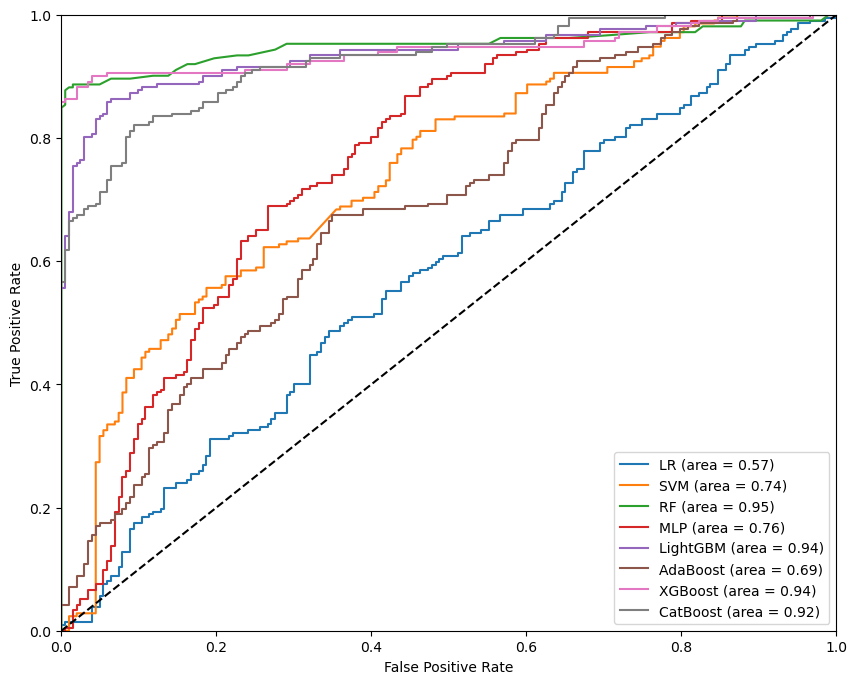

Metric Results:


,Classifier,ROC AUC,Sensitivity,Specificity,F1 Score,Accuracy,PPV,NPV
0,LR,0.574914,0.542453,0.581281,0.558252,0.561446,0.575000,0.548837
1,SVM,0.741844,0.688679,0.625616,0.672811,0.657831,0.657658,0.658031
2,RF,0.950774,0.900943,0.881773,0.894614,0.891566,0.888372,0.895000
3,MLP,0.763268,0.716981,0.679803,0.708625,0.698795,0.700461,0.696970
4,LightGBM,0.936844,0.900943,0.793103,0.858427,0.848193,0.819742,0.884615
5,AdaBoost,0.687308,0.683962,0.566502,0.651685,0.626506,0.622318,0.631868
6,XGBoost,0.943745,0.905660,0.827586,0.874715,0.867470,0.845815,0.893617
7,CatBoost,0.924923,0.844340,0.832512,0.842353,0.838554,0.840376,0.836634


In [50]:
'''Lasso'''
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Load data
data = pd.read_csv('scaled_data_with_RandomOverSampler.csv')

# Separate target variable and features
y = data['Outcome']
X = data.drop(['Outcome', 'WBC', 'Neut%', 'MCHC', 'RDW'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a dictionary of classifiers
classifiers = {
    "LR": LogisticRegression(),
    "SVM": SVC(probability=True),
    "RF": RandomForestClassifier(),
    "MLP": MLPClassifier(),
    "LightGBM": LGBMClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(silent=True)
}

results = []  # DataFrame to store evaluation results

# Prepare to plot ROC curves
plt.figure(figsize=(10, 8))

# Loop through each classifier
for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Get predicted probabilities for the positive class
    y_pred = clf.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate the area under the curve

    # Plot ROC curve for each classifier
    plt.plot(fpr, tpr, label=f'{clf_name} (area = {roc_auc:.2f})')

    # Compute metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Sensitivity
    specificity = (confusion_matrix(y_test, y_pred)[0, 0]) / (confusion_matrix(y_test, y_pred)[0, 0] + confusion_matrix(y_test, y_pred)[0, 1])
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    ppv = precision  # Positive Predictive Value
    npv = (confusion_matrix(y_test, y_pred)[0, 0]) / (confusion_matrix(y_test, y_pred)[0, 0] + confusion_matrix(y_test, y_pred)[1, 0])  # Negative Predictive Value

    # Append results
    results.append({
        "Classifier": clf_name,
        "ROC AUC": roc_auc,
        "Sensitivity": recall,
        "Specificity": specificity,
        "F1 Score": f1,
        "Accuracy": accuracy,
        "PPV": ppv,
        "NPV": npv
    })

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()

# Display the results
print('Metric Results:')
display(pd.DataFrame(results))

In [1]:
'''ttest'''
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Load data
data = pd.read_csv('scaled_data_with_RandomOverSampler.csv')

# Separate target variable and features
y = data['Outcome']
X = data[['WBC', 'ALC', 'AMC', 'ANC', 'PDW']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a dictionary of classifiers
classifiers = {
    "LR": LogisticRegression(),
    "SVM": SVC(probability=True),
    "RF": RandomForestClassifier(),
    "MLP": MLPClassifier(),
    "LightGBM": LGBMClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(silent=True)
}

results = []  # DataFrame to store evaluation results

# Prepare to plot ROC curves
plt.figure(figsize=(10, 8))

# Loop through each classifier
for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Get predicted probabilities for the positive class
    y_pred = clf.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate the area under the curve

    # Plot ROC curve for each classifier
    plt.plot(fpr, tpr, label=f'{clf_name} (area = {roc_auc:.2f})')

    # Compute metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Sensitivity
    specificity = (confusion_matrix(y_test, y_pred)[0, 0]) / (confusion_matrix(y_test, y_pred)[0, 0] + confusion_matrix(y_test, y_pred)[0, 1])
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    ppv = precision  # Positive Predictive Value
    npv = (confusion_matrix(y_test, y_pred)[0, 0]) / (confusion_matrix(y_test, y_pred)[0, 0] + confusion_matrix(y_test, y_pred)[1, 0])  # Negative Predictive Value

    # Append results
    results.append({
        "Classifier": clf_name,
        "ROC AUC": roc_auc,
        "Sensitivity": recall,
        "Specificity": specificity,
        "F1 Score": f1,
        "Accuracy": accuracy,
        "PPV": ppv,
        "NPV": npv
    })

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()

# Display the results
print('Metric Results:')
display(pd.DataFrame(results))

d:\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


FileNotFoundError: [Errno 2] No such file or directory: 'dataset.xlsx'

d:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 825, number of negative: 834
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4180
[LightGBM] [Info] Number of data points in the train set: 1659, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497288 -> initscore=-0.010850
[LightGBM] [Info] Start training from score -0.010850


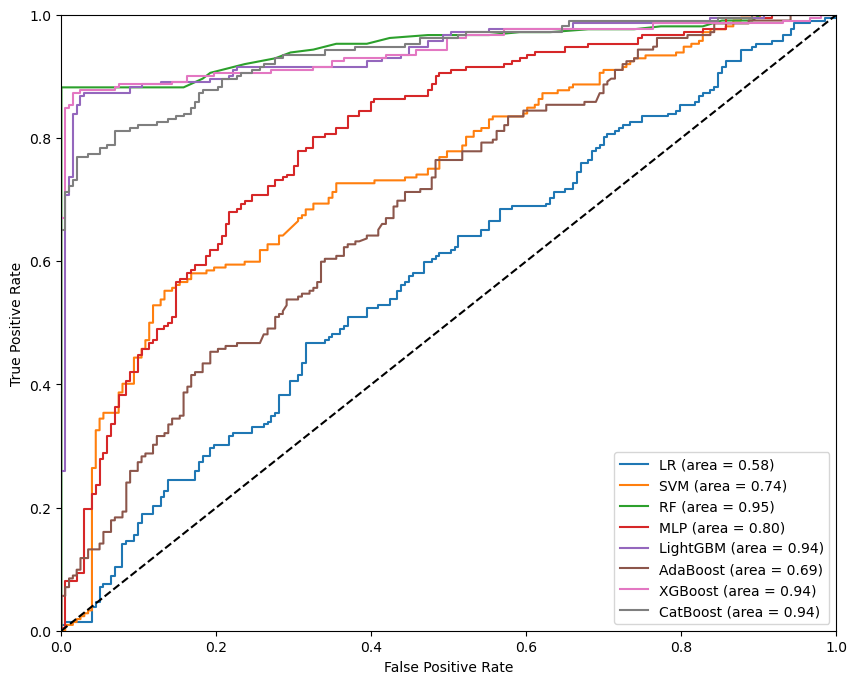

Metric Results:


,Classifier,ROC AUC,Sensitivity,Specificity,F1 Score,Accuracy,PPV,NPV
0,LR,0.577470,0.537736,0.571429,0.552058,0.554217,0.567164,0.542056
1,SVM,0.742657,0.683962,0.679803,0.687204,0.681928,0.690476,0.673171
2,RF,0.951308,0.882075,0.906404,0.894737,0.893976,0.907767,0.880383
3,MLP,0.796914,0.740566,0.699507,0.730233,0.720482,0.720183,0.720812
4,LightGBM,0.941630,0.891509,0.832512,0.868966,0.862651,0.847534,0.880208
5,AdaBoost,0.685507,0.660377,0.581281,0.640732,0.621687,0.622222,0.621053
6,XGBoost,0.942722,0.900943,0.817734,0.868182,0.860241,0.837719,0.887701
7,CatBoost,0.935659,0.877358,0.817734,0.855172,0.848193,0.834081,0.864583


In [52]:
'''Without Selection'''
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Load data
data = pd.read_csv('scaled_data_with_RandomOverSampler.csv')

# Separate target variable and features
y = data['Outcome']
X = data.drop(['Outcome'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a dictionary of classifiers
classifiers = {
    "LR": LogisticRegression(),
    "SVM": SVC(probability=True),
    "RF": RandomForestClassifier(),
    "MLP": MLPClassifier(),
    "LightGBM": LGBMClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(silent=True)
}

results = []  # DataFrame to store evaluation results

# Prepare to plot ROC curves
plt.figure(figsize=(10, 8))

# Loop through each classifier
for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Get predicted probabilities for the positive class
    y_pred = clf.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate the area under the curve

    # Plot ROC curve for each classifier
    plt.plot(fpr, tpr, label=f'{clf_name} (area = {roc_auc:.2f})')

    # Compute metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Sensitivity
    specificity = (confusion_matrix(y_test, y_pred)[0, 0]) / (confusion_matrix(y_test, y_pred)[0, 0] + confusion_matrix(y_test, y_pred)[0, 1])
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    ppv = precision  # Positive Predictive Value
    npv = (confusion_matrix(y_test, y_pred)[0, 0]) / (confusion_matrix(y_test, y_pred)[0, 0] + confusion_matrix(y_test, y_pred)[1, 0])  # Negative Predictive Value

    # Append results
    results.append({
        "Classifier": clf_name,
        "ROC AUC": roc_auc,
        "Sensitivity": recall,
        "Specificity": specificity,
        "F1 Score": f1,
        "Accuracy": accuracy,
        "PPV": ppv,
        "NPV": npv
    })

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()

# Display the results
print('Metric Results:')
display(pd.DataFrame(results))

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('scaled_data_with_RandomOverSampler.csv')

# Separate target variable and features
y = data['Outcome'] # Ensure proper shape
X = data.drop(['Outcome'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Fit XGBoost model
xgb_model = RandomForestClassifier()
xgb_model.fit(X_train, y_train)

# Get feature importance
importance = xgb_model.feature_importances_

# Sort feature importance in descending order
sorted_idx = np.argsort(importance)[::-1]

# Get feature names
feature_names = X.columns

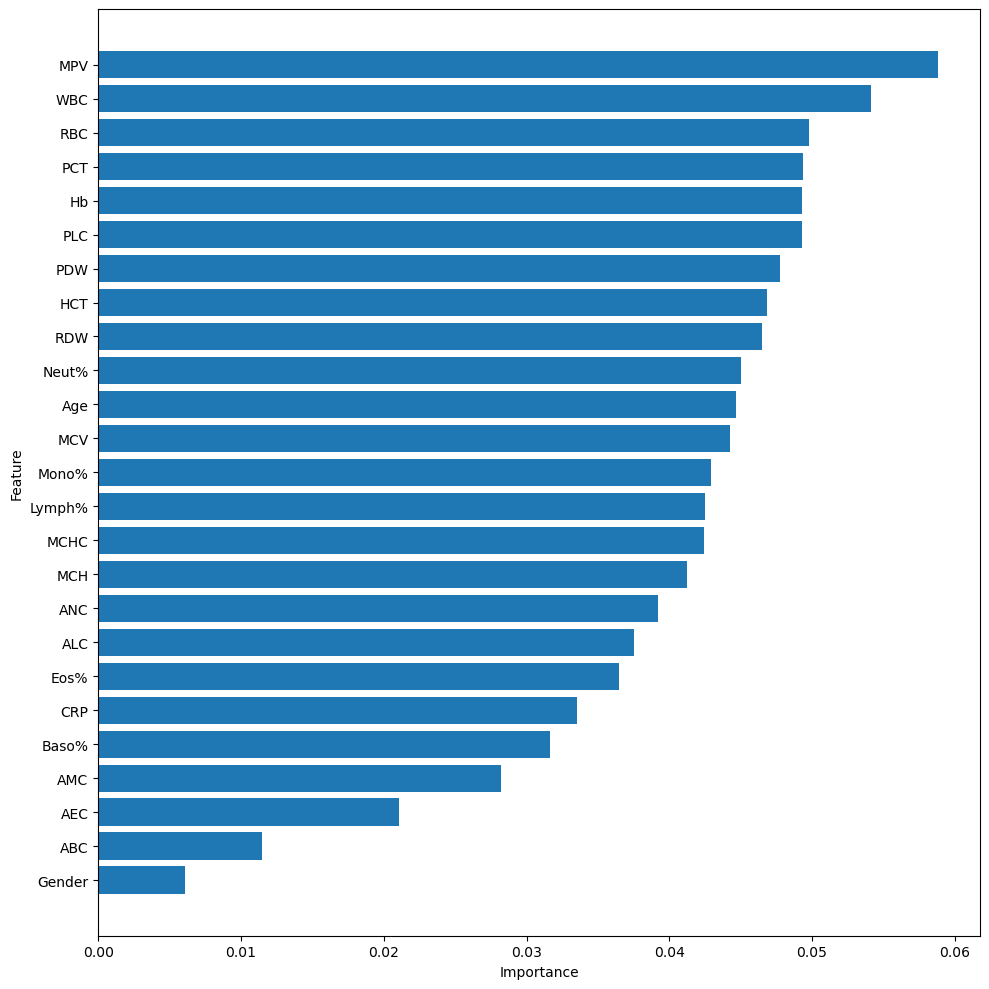

In [3]:
# Plot feature importance
plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]), importance[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), feature_names[sorted_idx])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Reverse y-axis
plt.tight_layout()
plt.show()

In [2]:
import shap
plt.figure(figsize=(10,10))
# Use SHAP to explain the model's predictions
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer.shap_values(X_train,check_additivity=False)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train)

NameError: name '_C' is not defined